#### 이탈 고객 예측

#### 데이터 전처리(켤측치 처리, 클래스불균형 확인 및 처리)
#### 특성공학 - 피처선정 또는 피처생성

#### 베이스 모델 선정
        - 분류모델 : LogisticRegression
        - 클래스 리포트, 과적합여부

In [114]:
import pandas as pd
url = "https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/tellecom.csv"
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---
## 🎯 LogisticRegression을 위한 전처리 전략
- **스케일링 필수**: 선형 모델이라 특성 범위에 민감
- **범주형 인코딩**: One-Hot Encoding 적용
- **클래스 불균형 처리**: class_weight='balanced' 사용
- **Pipeline 구성**: 데이터 누수 방지

In [115]:
# Step 1: 범주형 변수 카디널리티 확인
cat_cols = df.select_dtypes(include=['object']).columns
print("📊 범주형 변수별 고유값 개수:")
print("=" * 50)
for col in cat_cols:
    if col != 'Churn':  # Churn은 이미 인코딩됨
        n_unique = df[col].nunique()
        print(f"{col:20s}: {n_unique:3d}개 고유값")
        if n_unique <= 10:
            print(f"  → {df[col].value_counts().to_dict()}")
print("=" * 50)

📊 범주형 변수별 고유값 개수:
customerID          : 7043개 고유값
gender              :   2개 고유값
  → {'Male': 3555, 'Female': 3488}
Partner             :   2개 고유값
  → {'No': 3641, 'Yes': 3402}
Dependents          :   2개 고유값
  → {'No': 4933, 'Yes': 2110}
PhoneService        :   2개 고유값
  → {'Yes': 6361, 'No': 682}
MultipleLines       :   3개 고유값
  → {'No': 3390, 'Yes': 2971, 'No phone service': 682}
InternetService     :   3개 고유값
  → {'Fiber optic': 3096, 'DSL': 2421, 'No': 1526}
OnlineSecurity      :   3개 고유값
  → {'No': 3498, 'Yes': 2019, 'No internet service': 1526}
OnlineBackup        :   3개 고유값
  → {'No': 3088, 'Yes': 2429, 'No internet service': 1526}
DeviceProtection    :   3개 고유값
  → {'No': 3095, 'Yes': 2422, 'No internet service': 1526}
TechSupport         :   3개 고유값
  → {'No': 3473, 'Yes': 2044, 'No internet service': 1526}
StreamingTV         :   3개 고유값
  → {'No': 2810, 'Yes': 2707, 'No internet service': 1526}
StreamingMovies     :   3개 고유값
  → {'No': 2785, 'Yes': 2732, 'No internet service': 

In [116]:
# Step 2: 데이터 재로드 및 전처리 시작 (클린 상태)
url = "https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/tellecom.csv"
df_clean = pd.read_csv(url)
df_clean = df_clean.drop(['customerID','TotalCharges'], axis=1)
    

# 타겟 변수 인코딩
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

# 특성과 타겟 분리
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

print(f"✅ 데이터 로드 완료: {X.shape[0]}행, {X.shape[1]}개 특성")
print(f"✅ 타겟 분포:\n{y.value_counts()}")
print(f"   불균형 비율: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

✅ 데이터 로드 완료: 7043행, 18개 특성
✅ 타겟 분포:
Churn
0    5174
1    1869
Name: count, dtype: int64
   불균형 비율: 2.77:1


In [117]:
# Step 3: 범주형 변수 One-Hot Encoding
# 3-1. 서비스 관련 값 통합 ('No phone service', 'No internet service' → 'No')
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

print("🔧 서비스 관련 범주형 값 통합 중...")
for col in service_cols:
    if col in X.columns:
        before_count = X[col].nunique()
        X[col] = X[col].replace(['No phone service', 'No internet service'], 'No')
        after_count = X[col].nunique()
        if before_count != after_count:
            print(f"  ✅ {col}: {before_count}개 → {after_count}개 고유값")

# 3-2. One-Hot Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"\n✅ One-Hot Encoding 완료:")
print(f"   변환 전: {X.shape[1]}개 특성")
print(f"   변환 후: {X_encoded.shape[1]}개 특성 (증가: {X_encoded.shape[1] - X.shape[1]}개)")
print(f"\n생성된 특성 샘플 (처음 10개):")
print(list(X_encoded.columns[:10]))


🔧 서비스 관련 범주형 값 통합 중...
  ✅ MultipleLines: 3개 → 2개 고유값
  ✅ OnlineSecurity: 3개 → 2개 고유값
  ✅ OnlineBackup: 3개 → 2개 고유값
  ✅ DeviceProtection: 3개 → 2개 고유값
  ✅ TechSupport: 3개 → 2개 고유값
  ✅ StreamingTV: 3개 → 2개 고유값
  ✅ StreamingMovies: 3개 → 2개 고유값

✅ One-Hot Encoding 완료:
   변환 전: 18개 특성
   변환 후: 22개 특성 (증가: 4개)

생성된 특성 샘플 (처음 10개):
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No']


In [118]:
# Step 4: 데이터 분할 (Stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # 클래스 비율 유지
)

print(f"✅ 데이터 분할 완료:")
print(f"   학습 세트: {X_train.shape[0]}개 ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"   테스트 세트: {X_test.shape[0]}개 ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"\n학습 세트 클래스 분포:")
print(y_train.value_counts())
print(f"테스트 세트 클래스 분포:")
print(y_test.value_counts())

✅ 데이터 분할 완료:
   학습 세트: 5634개 (80.0%)
   테스트 세트: 1409개 (20.0%)

학습 세트 클래스 분포:
Churn
0    4139
1    1495
Name: count, dtype: int64
테스트 세트 클래스 분포:
Churn
0    1035
1     374
Name: count, dtype: int64


### 🔧 방법 1: Pipeline 사용 (추천)
**장점**: 스케일링 누수 방지, 코드 간결, 재사용 용이

In [119]:
# Pipeline으로 스케일링 + LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Pipeline 구성
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),  # 1단계: 표준화
    ('model', LogisticRegression(
        class_weight='balanced',   # 클래스 불균형 자동 처리
        max_iter=1000,             # 수렴 보장
        random_state=42,
        solver='lbfgs'             # 기본 solver
    ))
])

# 학습
print("⏳ Pipeline 학습 중...")
pipe_lr.fit(X_train, y_train)
print("✅ 학습 완료!")

# 예측
y_pred_pipe = pipe_lr.predict(X_test)
y_pred_proba_pipe = pipe_lr.predict_proba(X_test)[:, 1]

⏳ Pipeline 학습 중...
✅ 학습 완료!


In [120]:
# Pipeline 모델 평가
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("=" * 60)
print("📊 LogisticRegression (Pipeline) 평가 결과")
print("=" * 60)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_pipe)
print("\n혼동 행렬:")
print(cm)
print(f"\nTP(진양성): {cm[1,1]}, FN(위음성): {cm[1,0]}")
print(f"FP(위양성): {cm[0,1]}, TN(진음성): {cm[0,0]}")

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_test, y_pred_pipe, target_names=['No Churn', 'Churn']))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba_pipe)
print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

# 학습/테스트 정확도 비교 (과적합 확인)
train_score = pipe_lr.score(X_train, y_train)
test_score = pipe_lr.score(X_test, y_test)
print(f"\n📈 정확도 비교:")
print(f"   학습 세트: {train_score:.4f}")
print(f"   테스트 세트: {test_score:.4f}")
print(f"   차이: {abs(train_score - test_score):.4f}", end="")
if abs(train_score - test_score) > 0.05:
    print(" ⚠️ 과적합 가능성")
else:
    print(" ✅ 적절함")

📊 LogisticRegression (Pipeline) 평가 결과

혼동 행렬:
[[752 283]
 [ 83 291]]

TP(진양성): 291, FN(위음성): 83
FP(위양성): 283, TN(진음성): 752

분류 리포트:
              precision    recall  f1-score   support

    No Churn       0.90      0.73      0.80      1035
       Churn       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409


🎯 ROC-AUC Score: 0.8382

📈 정확도 비교:
   학습 세트: 0.7524
   테스트 세트: 0.7402
   차이: 0.0122 ✅ 적절함


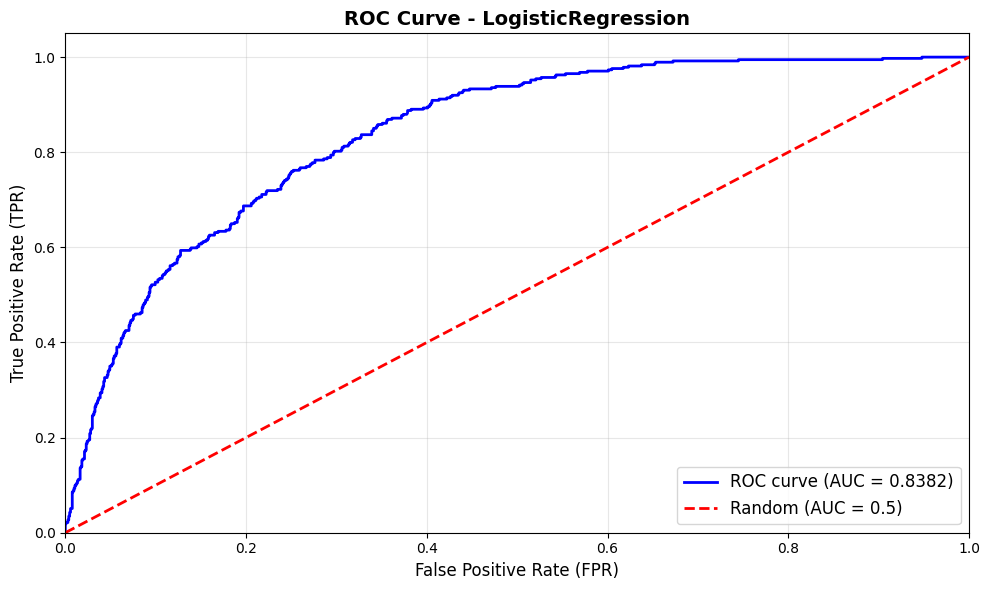

In [121]:
# ROC 곡선 시각화
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pipe)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve - LogisticRegression', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 🔍 특성 중요도 분석 (LogisticRegression 계수)

In [122]:
# LogisticRegression 계수 확인 (특성 중요도)
import numpy as np

# 모델에서 계수 추출
coefficients = pipe_lr.named_steps['model'].coef_[0]
feature_names = X_encoded.columns

# 계수 절댓값 기준 정렬 (영향력 큰 순서)
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Top 10 중요 특성
print("=" * 70)
print("📊 Top 10 중요 특성 (계수 절댓값 기준)")
print("=" * 70)
print(coef_df.head(10).to_string(index=False))

print("\n💡 해석:")
print("  - 양수 계수: 해당 특성이 증가하면 이탈 확률 증가")
print("  - 음수 계수: 해당 특성이 증가하면 이탈 확률 감소")
print("  - 절댓값이 클수록 영향력 큼")

📊 Top 10 중요 특성 (계수 절댓값 기준)
                       Feature  Coefficient  Abs_Coefficient
                MonthlyCharges    -0.854547         0.854547
   InternetService_Fiber optic     0.800513         0.800513
                        tenure    -0.753264         0.753264
            InternetService_No    -0.634802         0.634802
             Contract_Two year    -0.614972         0.614972
             Contract_One year    -0.298085         0.298085
           StreamingMovies_Yes     0.287581         0.287581
               StreamingTV_Yes     0.275927         0.275927
             MultipleLines_Yes     0.208202         0.208202
PaymentMethod_Electronic check     0.191375         0.191375

💡 해석:
  - 양수 계수: 해당 특성이 증가하면 이탈 확률 증가
  - 음수 계수: 해당 특성이 증가하면 이탈 확률 감소
  - 절댓값이 클수록 영향력 큼


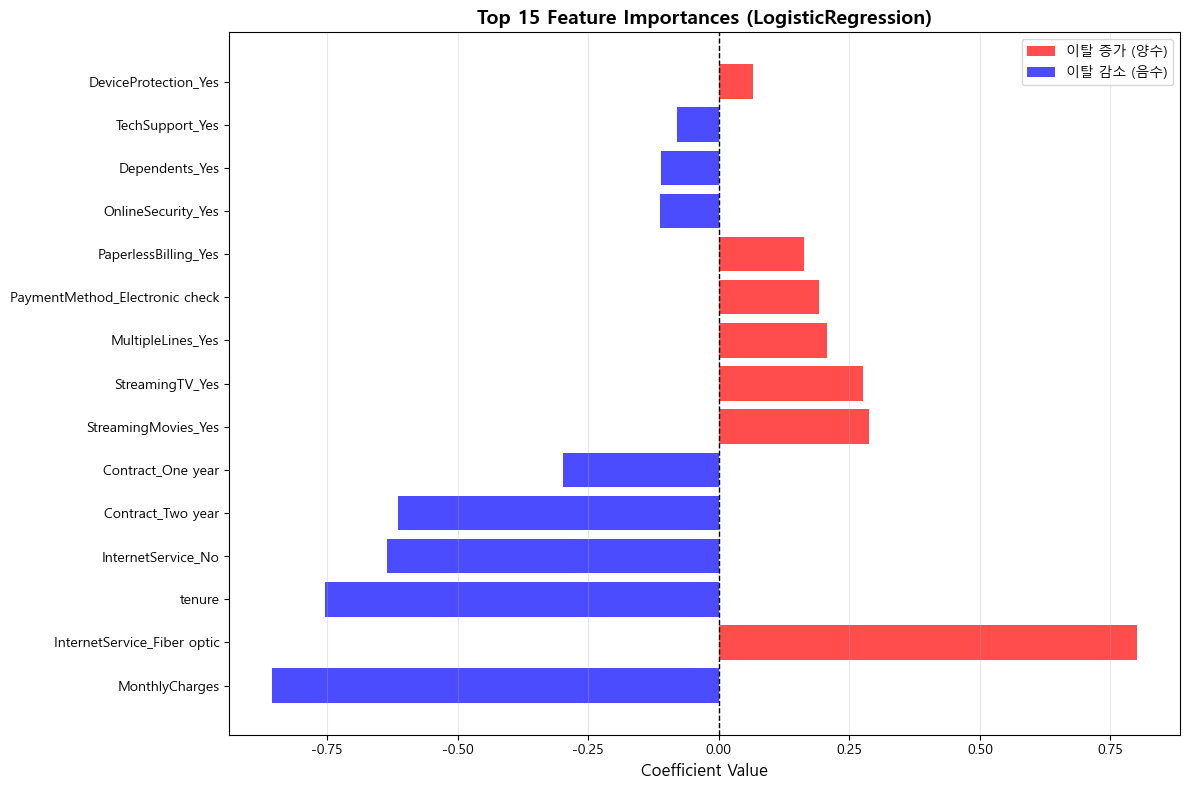

In [125]:
# 특성 중요도 시각화
# 한글화
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False    # 마이너스 기호 깨짐 방지
plt.figure(figsize=(12, 8))
top_features = coef_df.head(15)
colors = ['red' if x > 0 else 'blue' for x in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Feature Importances (LogisticRegression)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='이탈 증가 (양수)'),
    Patch(facecolor='blue', alpha=0.7, label='이탈 감소 (음수)')
]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

---
## 🔄 RandomForest vs LogisticRegression 비교

In [124]:
# RandomForest 재학습 (비교용)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 두 모델 성능 비교
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=" * 80)
print("📊 모델 성능 비교")
print("=" * 80)

models = {
    'LogisticRegression (Pipeline)': {
        'y_pred': y_pred_pipe,
        'y_proba': y_pred_proba_pipe,
        'train_score': train_score,
        'test_score': test_score
    },
    'RandomForest': {
        'y_pred': y_pred_rf,
        'y_proba': y_pred_proba_rf,
        'train_score': rf_model.score(X_train, y_train),
        'test_score': rf_model.score(X_test, y_test)
    }
}

comparison_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'ROC-AUC': [],
    'Train Acc': [],
    'Test Acc': [],
    'Overfit Gap': []
})

for model_name, results in models.items():
    comparison_df = pd.concat([comparison_df, pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy_score(y_test, results['y_pred'])],
        'Precision': [precision_score(y_test, results['y_pred'])],
        'Recall': [recall_score(y_test, results['y_pred'])],
        'F1-Score': [f1_score(y_test, results['y_pred'])],
        'ROC-AUC': [roc_auc_score(y_test, results['y_proba'])],
        'Train Acc': [results['train_score']],
        'Test Acc': [results['test_score']],
        'Overfit Gap': [abs(results['train_score'] - results['test_score'])]
    })], ignore_index=True)

print(comparison_df.to_string(index=False))

print("\n💡 해석:")
print("  - Accuracy: 전체 정확도")
print("  - Precision: 이탈 예측 중 실제 이탈 비율 (FP 최소화)")
print("  - Recall: 실제 이탈 중 찾아낸 비율 (FN 최소화) ⭐")
print("  - F1-Score: Precision과 Recall의 조화평균")
print("  - ROC-AUC: 불균형 데이터에서 종합 성능 지표")
print("  - Overfit Gap: 학습-테스트 차이 (작을수록 좋음)")

📊 모델 성능 비교
                        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Acc  Test Acc  Overfit Gap
LogisticRegression (Pipeline)  0.740241   0.506969 0.778075  0.613924 0.838247   0.752396  0.740241     0.012155
                 RandomForest  0.783534   0.615385 0.491979  0.546805 0.823721   0.997870  0.783534     0.214336

💡 해석:
  - Accuracy: 전체 정확도
  - Precision: 이탈 예측 중 실제 이탈 비율 (FP 최소화)
  - Recall: 실제 이탈 중 찾아낸 비율 (FN 최소화) ⭐
  - F1-Score: Precision과 Recall의 조화평균
  - ROC-AUC: 불균형 데이터에서 종합 성능 지표
  - Overfit Gap: 학습-테스트 차이 (작을수록 좋음)


### ✅ 결론 및 권장사항

**LogisticRegression 장점:**
- ✅ 해석력 뛰어남 (계수로 영향력 파악 가능)
- ✅ 빠른 학습 속도
- ✅ 과적합 위험 낮음
- ✅ 메모리 효율적

**RandomForest 장점:**
- ✅ 비선형 관계 포착
- ✅ 특성 스케일링 불필요
- ✅ 높은 예측 정확도

**추천:**
1. **해석이 중요한 경우** → LogisticRegression 
2. **정확도 최우선** → RandomForest 또는 XGBoost
3. **실무**: 둘 다 시도 후 비즈니스 요구사항에 맞게 선택